In [2]:
import tensorflow as tf
from utils import *

# AlexNet

In [3]:
class AlexNet(Classifier):
    def __init__(self, lr=0.1, num_outputs=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(
                96, kernel_size=11, strides=4, activation=tf.nn.relu),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
            tf.keras.layers.Conv2D(
                256, kernel_size=5, padding='same', activation=tf.nn.relu),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
            tf.keras.layers.Conv2D(
                384, kernel_size=3, padding='same', activation=tf.nn.relu),
            tf.keras.layers.Conv2D(
                384, kernel_size=3, padding='same', activation=tf.nn.relu),
            tf.keras.layers.Conv2D(
                256, kernel_size=3, padding='same', activation=tf.nn.relu),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(4096, activation=tf.nn.relu),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(4096, activation=tf.nn.relu),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_outputs)
        ])

Construct a single-channel data example with both height and width of 224 to observe the output shape of each layer. 

In [5]:
with try_gpu():
    AlexNet().layer_summary((1, 224, 224, 1))

Conv2D output shape:	 (1, 54, 54, 96)
MaxPooling2D output shape:	 (1, 26, 26, 96)
Conv2D output shape:	 (1, 26, 26, 256)
MaxPooling2D output shape:	 (1, 12, 12, 256)
Conv2D output shape:	 (1, 12, 12, 384)
Conv2D output shape:	 (1, 12, 12, 384)
Conv2D output shape:	 (1, 12, 12, 256)
MaxPooling2D output shape:	 (1, 5, 5, 256)
Flatten output shape:	 (1, 6400)
Dense output shape:	 (1, 4096)
Dropout output shape:	 (1, 4096)
Dense output shape:	 (1, 4096)
Dropout output shape:	 (1, 4096)
Dense output shape:	 (1, 10)


Compared to LeNet, the main change here is the use of a smaller learning rate and much slower training due to the deeper and wider network, the higher image resolution, and the more costly convolutions.

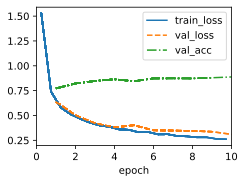

In [11]:
trainer = Trainer(max_epochs=10)
data = FashionMNIST(batch_size=128, resize=(224, 224))
with try_gpu():
    model = AlexNet(lr=0.01)
    trainer.fit(model, data)

Note that even though the number of parameters by far exceeds the amount of training data in our experiments (the last two layers have more than 40 million parameters, trained on a datasets of 60 thousand images), there is hardly any **overfitting**: training and validation loss are virtually identical throughout training. This is due to the improved regularization, such as ***Dropout***, inherent in modern deep network designs.

# Networks Using Blocks (VGG)
 

## VGG Block
A VGG block consists of a sequence of convolutions with 3x3 kernels with padding of 1 (keeping height and width) followed by a 2x2 max-pooling layer with stride of 2 (halving height and width after each block).

In [7]:
def vgg_block(num_convs, num_channels):
    blk = tf.keras.models.Sequential()
    for _ in range(num_convs):
        blk.add(
            tf.keras.layers.Conv2D(num_channels, kernel_size=3,
                                   padding='same', activation='relu')
        )
        blk.add(
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
        )
    return blk

## VGG Network
The key difference is that VGG consists of blocks of layers, the convolutional layers are grouped in nonlinear transformations that leave the dimensonality unchanged, followed by a resolution-reduction step
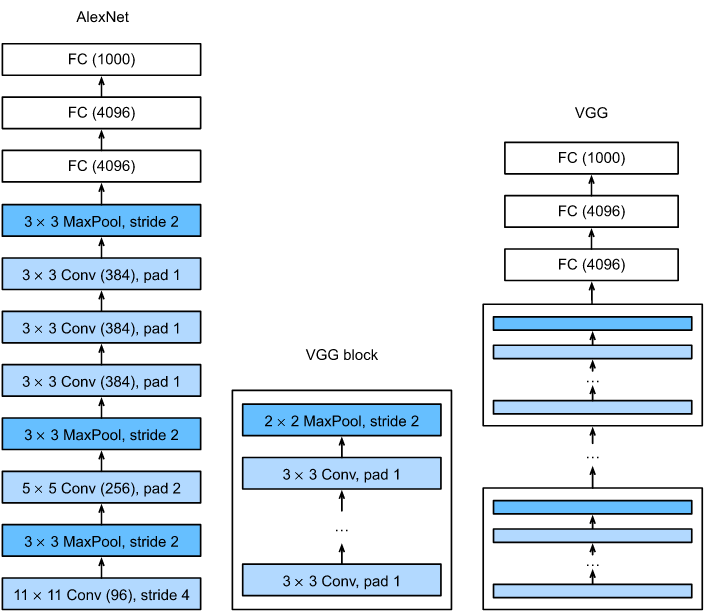

In [8]:
class VGG(Classifier):
    def __init__(self, arch, lr=0.1, num_outputs=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential()
        
        for (num_convs, num_channels) in arch:
            self.net.add(vgg_block(num_convs, num_channels))
            
        self.net.add(
            tf.keras.models.Sequential([
                tf.keras.layers.Flatten()
                tf.keras.layers.Dense(4096, activation='relu'),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(4096, activation='relu'),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(num_outputs)
            ])
        )
